<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Business Analytics e Machine Learning Para Projetos de Data Science</font>
## <font color='blue'>Projeto 12</font>
### <font color='blue'>Blockchain Analytics Para Criptoativos com Machine Learning</font>

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Instalando e Carregando Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
# Instala todos os pacotes e dependências
!pip install -r requirements.txt -q

In [3]:
# Imports
import rich
import torch
import langid
import sklearn
import datasets
import transformers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from rich.progress import track
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('max_colwidth', None)

In [5]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Carregando e Compreendendo os Dados

In [6]:
# Carrega o dataset
df_dsa = pd.read_csv('dataset.csv')

In [7]:
# Shape
df_dsa.shape

(138, 4)

In [8]:
# Amostra
df_dsa.head()

,ID,Data,texto,sentimento
0,0,2024-07-01,Bitcoin atinge novo recorde histórico! #Bitcoin #Cripto,Positivo
1,1,2024-07-01,Ethereum está revolucionando o mercado de contratos inteligentes.,Positivo
2,2,2024-07-01,Cardano e Polkadot são as criptomoedas mais promissoras do ano.,Positivo
3,3,2024-07-01,"Investir em criptomoedas pode ser arriscado, mas também muito lucrativo.",Positivo
4,4,2024-07-01,A adoção de Bitcoin como moeda legal em países emergentes está crescendo.,Positivo


In [9]:
# Contagem de registros por classe
sentiment_count = df_dsa['sentimento'].value_counts()

In [10]:
print(sentiment_count)

sentimento
Positivo    50
Negativo    48
Neutro      40
Name: count, dtype: int64


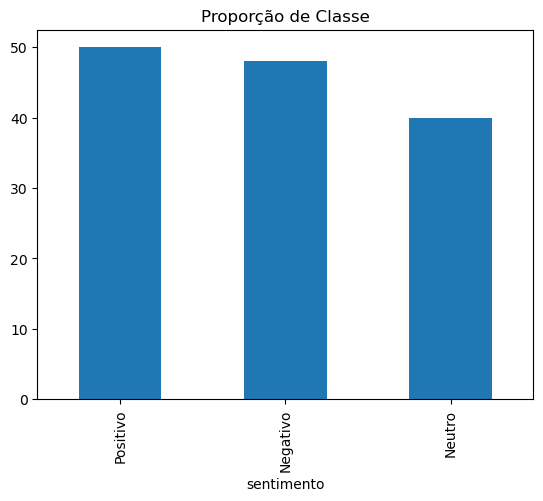

In [11]:
# Visualizando a proporção de classes
df_dsa['sentimento'].value_counts().plot(kind = 'bar', title = 'Proporção de Classe');

## Detecção Automática de Idioma dos Dados

In [12]:
# Cria uma nova coluna no dataframe
df_dsa['lang'] = None

In [13]:
# Amostra
df_dsa.head()

,ID,Data,texto,sentimento,lang
0,0,2024-07-01,Bitcoin atinge novo recorde histórico! #Bitcoin #Cripto,Positivo,None
1,1,2024-07-01,Ethereum está revolucionando o mercado de contratos inteligentes.,Positivo,None
2,2,2024-07-01,Cardano e Polkadot são as criptomoedas mais promissoras do ano.,Positivo,None
3,3,2024-07-01,"Investir em criptomoedas pode ser arriscado, mas também muito lucrativo.",Positivo,None
4,4,2024-07-01,A adoção de Bitcoin como moeda legal em países emergentes está crescendo.,Positivo,None


In [14]:
# Loop para percorrer cada linha do DataFrame e detectar o idioma do texto
for index, row in track(df_dsa.iterrows(), total = len(df_dsa)):
    
    # Extrai o texto da coluna 'texto' da linha atual
    text = row['texto']
    
    # Verifica se o texto é uma string válida
    if isinstance(text, str):
        
        # Classifica o idioma do texto e obtém a confiança da classificação
        language, confidence = langid.classify(text)
        
        # Atribui o idioma detectado à coluna 'lang' no DataFrame
        df_dsa.at[index, 'lang'] = language
    else:
        
        # Se o texto não for uma string válida, marca o idioma como 'desconhecido'
        df_dsa.at[index, 'lang'] = 'desconhecido'

Output()

In [15]:
# Amostra
df_dsa.sample(10)

,ID,Data,texto,sentimento,lang
24,24,2024-07-01,O aumento da adoção de criptomoedas está impulsionando o mercado.,Positivo,pt
2,2,2024-07-01,Cardano e Polkadot são as criptomoedas mais promissoras do ano.,Positivo,pt
14,14,2024-07-01,O interesse em criptomoedas está crescendo entre jovens investidores.,Positivo,pt
106,106,2024-07-01,"As criptomoedas estão ganhando espaço, mas ainda enfrentam desafios.",Neutro,pt
63,63,2024-07-01,O uso ilícito de criptomoedas está aumentando.,Negativo,pt
64,64,2024-07-01,A adoção de criptomoedas está enfrentando resistência em muitos setores.,Negativo,pt
44,44,2024-07-01,Muitos especialistas acreditam no potencial de valorização do Bitcoin.,Positivo,pt
10,10,2024-07-01,Bitcoin pode chegar a valer mais de 100 mil dólares nos próximos anos.,Positivo,gl
81,81,2024-07-01,A falta de proteção ao consumidor no mercado cripto é preocupante.,Negativo,pt
128,128,2024-07-01,A adoção de criptomoedas está impulsionando o desenvolvimento de novas tecnologias.,Neutro,pt


## Limpeza dos Dados

In [16]:
# Vamos usar somente registros com texto detectado como português
df_dsa = df_dsa[df_dsa['lang'] == 'pt']

In [17]:
# Shape
df_dsa.shape

(129, 5)

https://docs.python.org/3.11/library/re.html

In [18]:
# Aplica expressão regular para limpar o texto
df_dsa['texto'] = df_dsa['texto'].str.replace(r'http\S+', '', regex=True).str.replace(r'#\w+', '', regex=True).str.replace(r'@\w+', '', regex=True).str.replace(r'\d+', '', regex=True)         

Explicação detalhada da linha de código acima.

**df_dsa['texto'].str.replace(r'http\S+', '', regex=True):**

Função: Substitui todas as URLs por uma string vazia, removendo-as do texto.

Expressão Regular r'http\S+':

http: Procura por qualquer sequência de caracteres que começa com "http".

\S+: Combina qualquer sequência de caracteres que não sejam espaços (representando o resto da URL).

Resultado: URLs completas (por exemplo, "http://example.com") são removidos do texto.

**str.replace(r'#\w+', '', regex=True):**

Função: Remove hashtags do texto.

Expressão Regular r'#\w+':

#: Procura pelo caractere de hashtag.

\w+: Combina uma sequência de caracteres alfanuméricos (letras, números ou underscore), que representa o conteúdo da hashtag.

Resultado: Hashtags como "#Bitcoin" são removidas do texto.

**str.replace(r'@\w+', '', regex=True):**

Função: Remove menções de usuário do texto (por exemplo, "@username").

Expressão Regular r'@\w+':

@: Procura pelo caractere de arroba.

\w+: Combina uma sequência de caracteres alfanuméricos (letras, números ou underscore), representando o nome do usuário.

Resultado: Menções como "@user123" são removidas do texto.

**str.replace(r'\d+', '', regex=True):**

Função: Remove todos os números do texto.

Expressão Regular r'\d+':

\d+: Combina uma ou mais ocorrências de dígitos (números).

Resultado: Sequências de números, como "2023" ou "123", são removidas do texto.

In [19]:
# Mapeamento de sentimento para valor numérico
sentiment_mapping = {'Negativo': 0, 'Neutro': 1, 'Positivo': 2}

In [20]:
# Aplica o mapeamento e cria uma nova coluna
df_dsa['label'] = df_dsa['sentimento'].map(sentiment_mapping)

In [21]:
# Amostra
df_dsa.sample(10)

,ID,Data,texto,sentimento,lang,label
115,115,2024-07-01,A adoção de criptomoedas varia amplamente entre os países.,Neutro,pt,1
118,118,2024-07-01,"As criptomoedas estão criando novas oportunidades, mas também riscos.",Neutro,pt,1
37,37,2024-07-01,Os contratos inteligentes do Ethereum estão mudando a forma de fazer negócios.,Positivo,pt,2
98,98,2024-07-01,Regulamentações para criptomoedas estão sendo discutidas globalmente.,Neutro,pt,1
73,73,2024-07-01,Os críticos dizem que as criptomoedas são uma moda passageira.,Negativo,pt,0
89,89,2024-07-01,Os reguladores estão pressionando por maior controle sobre o mercado cripto.,Negativo,pt,0
93,93,2024-07-01,As perdas no mercado cripto estão causando preocupações entre investidores.,Negativo,pt,0
3,3,2024-07-01,"Investir em criptomoedas pode ser arriscado, mas também muito lucrativo.",Positivo,pt,2
8,8,2024-07-01,Criptoativos são a nova fronteira da inovação financeira.,Positivo,pt,2
81,81,2024-07-01,A falta de proteção ao consumidor no mercado cripto é preocupante.,Negativo,pt,0


## Ajuste Fino do Modelo de Análise de Sentimento

https://huggingface.co/google-bert/bert-base-uncased

In [22]:
# Define o modelo
modelo = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ao carregar o modelo pré-treinado bert-base-uncased, o Hugging Face Transformers carrega os pesos para as camadas do modelo BERT, que foram treinados em uma tarefa de pré-treinamento (por exemplo, predição de palavras mascaradas).

No entanto, as camadas específicas de classificação (como classifier.bias e classifier.weight) não são carregadas a partir do checkpoint do modelo pré-treinado. Isso ocorre porque essas camadas não existiam no modelo original de pré-treinamento.

Essas camadas são "novas", criadas para a tarefa específica de classificação que você está definindo (BertForSequenceClassification com num_labels = 3). Portanto, os pesos dessas camadas são inicializados aleatoriamente.

A mensagem sugere que você deve treinar o modelo em uma tarefa específica ("down-stream task") com seus próprios dados. Isso é exatamente o que iremos fazer.

In [23]:
# Define o tokenizador
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [24]:
# Cria uma função para aplicar a tokenização
def dsa_tokeniza_dados(examples):
    return tokenizer(examples['texto'], padding = 'max_length', truncation = True)

In [25]:
# Coloca os dados no formato Dataset para acelerar a performance do treinamento
dataset = Dataset.from_pandas(df_dsa[['texto', 'label']])

In [26]:
type(dataset)

datasets.arrow_dataset.Dataset

In [27]:
# Aplica a tokenização aos dados
tokenized_datasets = dataset.map(dsa_tokeniza_dados, batched = True)

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

In [28]:
tokenized_datasets

Dataset({
    features: ['texto', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 129
})

In [29]:
tokenized_datasets[0]

{'texto': 'Bitcoin atinge novo recorde histórico!  ',
 'label': 2,
 '__index_level_0__': 0,
 'input_ids': [101,
  2978,
  3597,
  2378,
  2012,
  23496,
  24576,
  2501,
  2063,
  3181,
  2080,
  999,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [30]:
# Proporção de divisão dos dados em treino e teste
train_test_split_ratio = 0.8

In [31]:
# Cria o split de divisão dos dados em treino e teste
split = tokenized_datasets.train_test_split(test_size = 1 - train_test_split_ratio)

In [32]:
# Define os dados de treino e teste
dataset_treino = split['train']
dataset_teste = split['test']

## Função de Cálculo das Métricas

In [33]:
# Define a função para calcular as métricas
def dsa_calcula_metricas(p):
    
    # Obtém as previsões a partir das probabilidades, escolhendo a classe com maior probabilidade
    preds = np.argmax(p.predictions, axis = 1)
    
    # Calcula as métricas de precisão, recall e F1-score usando a média ponderada
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average = 'weighted')
    
    # Calcula a acurácia das previsões
    acc = accuracy_score(p.label_ids, preds)
    
    # Retorna um dicionário com as métricas calculadas: acurácia, F1-score, precisão e recall
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

## Definindo os Argumentos de Treino

Veja a descrição dos parâmetros no videobook do Capítulo 20 do curso.

In [34]:
# Define training arguments
training_args = TrainingArguments(output_dir = './resultados',
                                  eval_strategy = 'epoch',
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = 8,  
                                  per_device_eval_batch_size = 8,
                                  num_train_epochs = 10,
                                  weight_decay = 0.01,
                                  gradient_accumulation_steps = 2,
                                  logging_steps = 2)

In [35]:
# Cria o data collator
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

A linha acima cria uma instância de DataCollatorWithPadding, que é uma classe do Hugging Face Transformers. Ela é usada para preparar os lotes de dados (batches) de entrada para o modelo de forma que todos os itens em um lote tenham o mesmo comprimento.

**Preenchimento Dinâmico (Padding):**

Textos de entrada podem ter comprimentos variados. Para processá-los em paralelo no modelo, é necessário que todos os textos em um lote tenham o mesmo comprimento.

DataCollatorWithPadding aplica preenchimento (padding) automaticamente, adicionando tokens de preenchimento ([PAD]) ao final dos textos mais curtos até que todos os textos no lote tenham o mesmo comprimento que o mais longo.

**Integração com o Tokenizer:**

O tokenizer é passado como argumento para o DataCollatorWithPadding porque ele sabe qual token deve ser usado para o preenchimento e como aplicar esse preenchimento de forma consistente com o vocabulário e as regras do modelo.

**Facilita o Processamento em Batches:**

Quando você treina ou avalia o modelo em batches, DataCollatorWithPadding assegura que todos os textos em um batch tenham o mesmo comprimento, facilitando o processamento eficiente pelo modelo. Isso é especialmente útil quando se usa o DataLoader para carregar os dados em batches para o treinamento.

## Treinamento do Modelo Para Ajuste Fino

In [36]:
# Cria o objeto de treinamento do modelo
dsa_treina_modelo = Trainer(model = modelo,
                            args = training_args,
                            train_dataset = dataset_treino,
                            eval_dataset = dataset_teste,
                            tokenizer = tokenizer,
                            data_collator = data_collator,
                            compute_metrics = dsa_calcula_metricas)

In [37]:
%%time
dsa_treina_modelo.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,1.127700,1.063336,0.500000,0.414148,0.393002,0.500000
2,0.970400,0.993990,0.461538,0.378698,0.334842,0.461538
4,0.815900,1.000468,0.423077,0.358358,0.349817,0.423077
6,0.802000,0.975118,0.576923,0.527421,0.586538,0.576923
8,0.664600,0.960485,0.576923,0.572470,0.570330,0.576923
9,0.624700,0.960599,0.576923,0.572470,0.570330,0.576923


CPU times: user 12.7 s, sys: 3.43 s, total: 16.1 s
Wall time: 54 s


TrainOutput(global_step=60, training_loss=0.8640794714291891, metrics={'train_runtime': 53.7088, 'train_samples_per_second': 19.177, 'train_steps_per_second': 1.117, 'total_flos': 250220860259328.0, 'train_loss': 0.8640794714291891, 'epoch': 9.23076923076923})

## Avaliando e Salvando o Modelo Para Deploy

In [38]:
# Avalia o modelo treinado
eval_result = dsa_treina_modelo.evaluate()
print(eval_result)

{'eval_loss': 0.9605991840362549, 'eval_accuracy': 0.5769230769230769, 'eval_f1': 0.5724696356275304, 'eval_precision': 0.5703296703296703, 'eval_recall': 0.5769230769230769, 'eval_runtime': 0.583, 'eval_samples_per_second': 44.599, 'eval_steps_per_second': 6.861, 'epoch': 9.23076923076923}


In [39]:
# Salva modelo e tokenizador
modelo.save_pretrained('./dsa_modelo_final')
tokenizer.save_pretrained('./dsa_modelo_final')

('./dsa_modelo_final/tokenizer_config.json',
 './dsa_modelo_final/special_tokens_map.json',
 './dsa_modelo_final/vocab.txt',
 './dsa_modelo_final/added_tokens.json')

In [40]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [41]:
#%watermark -v -m

In [42]:
#%watermark --iversions

# Fim